In [220]:
# Import Libraries
import pandas as pd
import xlsxwriter
import matplotlib.pyplot as plt
import numpy as np

# Importing statistics libraries
import statsmodels.api as sm

#show plot in notebook
%matplotlib inline 

# Loading the Data

In [221]:
def load_data (dataframe, sheetname):
    '''This function loads an excel dataframe in a specified sheet'''
    #Loads the excel data using pandas 
    data = pd.read_excel(dataframe, sheetname)
    
    #Returning the data
    return data

In [222]:
# Testing the load data functions to see what the output table looks like
Salesdata = load_data ('../data/SalesDataA.xlsm', sheetname = 'Sales')
Adsdata = load_data ('../data/SalesDataA.xlsm', sheetname = 'Ads')
Adsdata.head()

,Ad Cost,Date
0,947.94,2013-08-01
1,936.06,2013-09-01
2,935.72,2013-10-01
3,930.47,2013-11-01
4,948.00,2013-12-01


# Cleaning the data

In [223]:
def clean_data(dataframe):
    '''Cleaning the dataframe and adding a new column of Sales in Canadian dollars'''
    # Renaming the columns 
    dataframe.columns = [['Exchange_Rate', 'Customer', 'Field', 'Date_of_Order', 'Total_Sales', 'Year_of_First_Order', 'New_or_Returning']]
    # Replacing the empty values in the Exchange Rate column with 1 and setting the index to Date_of_Order
    Sales_df= dataframe[['Exchange_Rate', 'Customer', 'Field', 'Date_of_Order', 'Total_Sales', 'Year_of_First_Order', 'New_or_Returning']].replace([None], [1]).set_index('Date_of_Order')
    # Creating a new column in the data set, which puts all sales amounts in Canadian dollars. 
    Sales_df['Sales_in_CAD'] = Sales_df['Exchange_Rate'] * Sales_df['Total_Sales']
    
    return Sales_df

In [224]:
Cleaneddata = clean_data(Salesdata)
Cleaneddata.head()

,Exchange_Rate,Customer,Field,Total_Sales,Year_of_First_Order,New_or_Returning,Sales_in_CAD
Date_of_Order,,,,,,,
2010-08-04,1,ABB Australia,engine technology,1897.60,1,Returning,1897.60
2010-08-16,1,A&A Metal Products,engine technology,28963.00,1,Returning,28963.00
2010-08-20,1,Analytical Engineer.,engine technology,76339.00,1,Returning,76339.00
2010-08-27,1,Bombardier Inc.,aerospace,24318.92,1,New,24318.92
2010-09-15,1,Beef Products Inc.,food,35084.00,1,New,35084.00


# PLOT 1:

# Merging the two Dataframes, and downsampling to Month

In [225]:
def merging_data(dataframe1, dataframe2):
    '''This function merges the two dataframes. Before merging the data, this function
    organizes the two dataframes so that the date columns in both dataframes are resampled 
    to month, and set as the index so that they can be merged by Date.'''
    
    # All rows with dates equal to and under 2013-07-31 will be deleted.
    Change_New = dataframe1[dataframe1.index > '2013-07-31'].reset_index()
    # Deleting all rows of sales from returning customers, to obtain Sales only from new customers. 
    Change1_New = Change_New.groupby(['New_or_Returning']).get_group('New')
    # Grabbing 3 columns from the dataset and setting the index to Date of order.
    Resampled_ind = Change1_New[['Date_of_Order', 'Sales_in_CAD', 'New_or_Returning']].set_index('Date_of_Order')
    # Replacing the 'New' string with the number 1 so that they can be added later.
    # And data is downsampled to month, taking the sum of the Sales and the new customers in each month. 
    Index_Month= Resampled_ind[['New_or_Returning', 'Sales_in_CAD']].replace(['New'], [1]).resample('M', how=('sum')) 
    
    # Setting the index to Date
    Ads_df = dataframe2.set_index('Date')
    # Renaming the columns
    Ads_df.columns = [['Ad_Cost']]
    # Resampling the date column, so that the month is synonymous with the other table 
    Ads1_df = Ads_df.resample('M', how=('sum'))
    
    # Now the two dataframes will be combined:
    # Combining the two dataframes by the date of order, and resetting the index.
    Combined_df = pd.concat([Index_Month, Ads1_df], axis=1, join_axes=[Index_Month.index]).reset_index()
    
    return Combined_df

In [226]:
# Testing the merging data function with dataframes
Combineddata = merging_data(Cleaneddata, Adsdata)
Combineddata.head()

,Date_of_Order,New_or_Returning,Sales_in_CAD,Ad_Cost
0,2013-08-31,3,7824.91800,947.94
1,2013-09-30,4,14447.37160,936.06
2,2013-10-31,5,10098.77148,935.72
3,2013-11-30,10,42933.68158,930.47
4,2013-12-31,5,38029.40040,948.00


# Running Linear Regression test on the data

In [227]:
def lm (x, y, data):
    '''This function calculates the linear regression of a scatter plot, where the 
    independent input variable is x and the dependant input variable is y.
    This function will print a summary of the results in a table.'''
    # Running linear regression on the plot 
    lm = sm.formula.ols(formula = 'y ~ x', data = data).fit()
    # generating a new data frame of the x variable, to produce a list of numbers from 1 to the same length as the x variable
    x_new = pd.DataFrame({'newdata' : range(1,len(x)+1)})
    # using the predict function to predict the y values based on x
    y_preds = lm.predict(x_new)
    
    summary = lm.summary()
    # printing the summary of the linear model
    print(summary)
    
    

In [228]:
# Testing the linear model function to print a table of the summary of the analysis
lm(Combineddata.Ad_Cost, Combineddata.Sales_in_CAD, Combineddata)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                 -0.031
Method:                 Least Squares   F-statistic:                    0.3157
Date:                Wed, 18 Nov 2015   Prob (F-statistic):              0.580
Time:                        06:35:37   Log-Likelihood:                -260.07
No. Observations:                  24   AIC:                             524.1
Df Residuals:                      22   BIC:                             526.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   2.621e+04   8874.566      2.954      0.0

# Creating a function that will plot the regression line

In [229]:
def plot_lm (x, y):
    '''This function plots the linear regression line of a given scatter plot,
    where x is the depedant variable and y is the independant vairable.'''
    # Adds a column of ones as long as the x column, which will allow the calculation of the intercept
    X = sm.add_constant(x)
    # Creates a linear model of the scatter plot 
    lm = sm.formula.OLS(y, X).fit()
    # Predicts the x values from x min to x max, using 24 different values 
    x_pred= np.linspace(x.min(),x.max(), 24)
    # Adds the column of ones previously created to the x value predictions
    x_pred2 = sm.add_constant(x_pred)
    # Predicts the y values, based on the x value predictions
    y_preds = lm.predict(x_pred2)
    
    # Plots the linear regression line using the predicted x values and the predicted y values
    plt.plot(x_pred, y_preds, color='k', linewidth = 2)
    
    return plt.plot()

# Creating a scatter plot with the linear regression line

In [230]:
def plot(x, y, z, plotname):
    '''This function will make 2 scatter plots, taking in data from three columns of a dataframe.
    The produced figure will be saved to a filename specified by the user in the input'''
    #Defining the size of the figure
    plt.figure(figsize=(13,5))
    
    #Making the fist subplot
    plt.subplot(1,2,1)
    # Creating a scatter plot from the dataframe
    plt.scatter(x, y)
    # Defining the y axis label
    plt.ylabel(y.name)
    # Defining the x-axis label 
    plt.xlabel(x.name)
    plot_lm(x, y)
    
    # Making the second subplot
    plt.subplot(1,2,2)
    plt.scatter(x, z)
    # Defining the y axis label
    plt.ylabel(z.name)
    # Defining the x-axis label 
    plt.xlabel(x.name)
    # Adding the linear model function, to plot the regression line on the plot
    plot_lm(x, z)
    
    #Saving the plot to a new file 
    plt.savefig(plotname)

C:\Users\mim\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


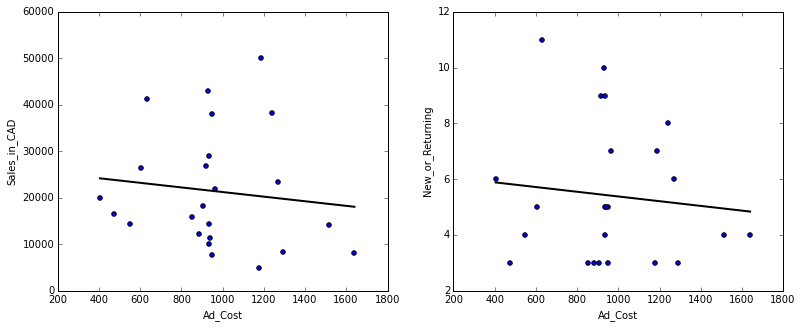

In [231]:
# Testing the plot function 
plot(Combineddata.Ad_Cost, Combineddata.Sales_in_CAD, Combineddata.New_or_Returning, 'plot.pdf')

# PLOT 2:

# Downsampling data to get two dataframes; one with New customers only, the other with returning customers only 

In [241]:
data = Cleaneddata[['New_or_Returning', 'Sales_in_CAD']]
# for g in df.groupby('New_or_Returning')
for g in data.New_or_Returning:
    data.get_group()


AttributeError: 'DataFrame' object has no attribute 'get_group'

In [240]:
data1

,Date_of_Order,New_or_Returning,Sales_in_CAD
0,2010-08-04,Returning,1897.60
1,2010-08-16,Returning,28963.00
2,2010-08-20,Returning,76339.00
3,2010-08-27,New,24318.92
4,2010-09-15,New,35084.00
5,2010-09-16,New,1563.00
6,2010-09-16,New,1550.00
7,2010-09-21,Returning,7219.00
8,2010-09-27,Returning,17622.61
9,2010-09-29,Returning,9795.00


In [212]:
def downsample_data(dataframe1):
    '''Downsampling the dataframe to containg only columns necessary for plotting'''
    # Getting the columns New or Returning and Sales in CAD with the Date of Order to get the amount of sales over time 
    data = dataframe1[['New_or_Returning', 'Sales_in_CAD']]
    #Creating a seperate dataframe with just returning customers
    Returning_C = data.groupby(['New_or_Returning']).get_group('Returning ').reset_index()
    
    return Returning_C
    
def downsample_data1(dataframe1):
    # Getting the columns New or Returning and Sales in CAD with the Date of Order to get the amount of sales over time 
    data = dataframe1[['New_or_Returning', 'Sales_in_CAD']]
    # Creating a seperate dataframe with just New customers
    New_C = data.groupby(['New_or_Returning']).get_group('New').reset_index()
    
    return New_C

In [215]:
# Testing the functions and visualizing the output
Returning = downsample_data(Cleaneddata)
New = downsample_data1(Cleaneddata)
New.head()

,Date_of_Order,New_or_Returning,Sales_in_CAD
0,2010-08-27,New,24318.92
1,2010-09-15,New,35084.00
2,2010-09-16,New,1563.00
3,2010-09-16,New,1550.00
4,2010-10-06,New,14357.60


# Plotting the data

In [213]:
def plot(data1column, data1column2, data2column, data2column2, plotname):
    '''This function creates 2 scatter plot of two different variables over time, 
    and saves the figure'''
    # Making a plot to compare Sales from New and Returning customers over time
    
    plt.figure(figsize = (15,10))
    
    #Making the fist subplot
    plt.subplot(2,1,1)
    plt.plot(data1column, data1column2, 'ro')
    plt.ylim(-500, 50000)
    plt.ylabel(data1column2.name)
    plt.title ('Sales to Returning Customers over Time')
    
    #Making the fist subplot
    plt.subplot(2,1,2)
    plt.plot(data2column, data2column2, 'go')
    plt.ylim(-500, 50000)
    plt.ylabel(data2column2.name)
    plt.title ('Sales to New Customers over Time')
    
    #Saving the plot to a new file 
    plt.savefig(plotname)

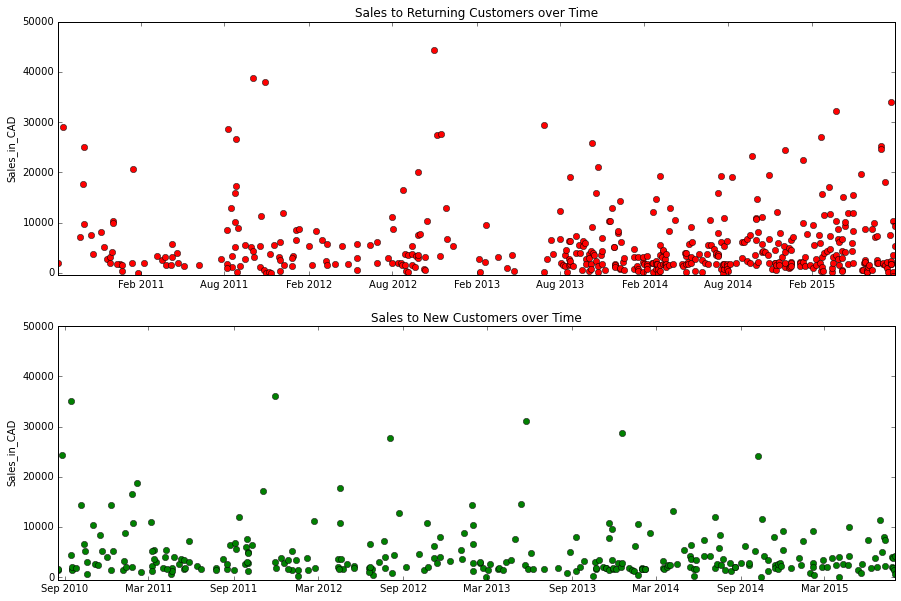

In [218]:
Typeplot = plot (Returning.Date_of_Order, Returning.Sales_in_CAD, New.Date_of_Order, New.Sales_in_CAD, 'plot.pdf')